## Estimating Mutual Information with Generative Adversarial Networks (GAN)

___
$\def\abs#1{\left\lvert #1 \right\rvert}
\def\Set#1{\left\{ #1 \right\}}
\def\mc#1{\mathcal{#1}}
\def\M#1{\boldsymbol{#1}}
\def\R#1{\mathsf{#1}}
\def\RM#1{\boldsymbol{\mathsf{#1}}}
\def\op#1{\operatorname{#1}}
\def\E{\op{E}}
\def\d{\mathrm{\mathstrut d}}$

In last section, we have proved that

$$
\begin{equation}
    I(\R{X}\wedge \R{Y}) = \mathop{\inf}_{p_{\R{X}'},p_{\R{Y}'}} D(p_{\R{X}\R{Y}}||p_{\R{X}'}p_{\R{Y}'}).
\end{equation}
$$

We can further apply the DV variational formulation:

$$
I(\mathsf{X}\wedge \mathsf{Y}) = \mathop{\inf}_{p_{\R{X}'}, p_{\R{Y}'}} \mathop{\sup}_{f\in\mathcal{F}} \left\{E[f(\R{X},\R{Y})]-\log E[e^{f(\R{X}',\R{Y}')}]  \right\}.
$$

We can construct generative models to simulate the sampling process of the variational distributions $p_{\R{X}'},p_{\R{Y}'}$, and then the training of these models represents the density updating process. More precisely, we build two multilayer generative neural networks denoted as $g^1,g^2$, where $g^1$ and $g^2$ are differentiable functions mapping from the Gaussian noise $\R{Z}_1, \R{Z}_2$ to the targets $\R{X}, \R{Y}$, respectively. The samples generated by $g^1,g^2$ can be viewed as drawn from the variational distributions $p_{\R{X}'}$ and $p_{\R{Y}'}$. Therefore, optimizing $p_{\R{X}'},p_{\R{Y}'}$ is equal to train the generative models $g^1,g^2$. 

We apply the **reparametrization trick** with $p_{\R{Z}_1},p_{\R{Z}_2}$, which can provide tractable gradient estimator of GAN-MINEE. With the change of variable rule, we have
\begin{equation}
    p_{\R{Z}_1}(z_1) = p_{\R{X}'}(g^1(z_1))\left|\det \frac{\partial g^1(z_1)}{\partial z_1}\right|.
\end{equation}

Then we can derive that
\begin{align}
    \mathbb{E}[e^{f(\R{X}',\R{Y}')}] 
    = \mathbb{E} [e^{f(g^1(\R{Z}_1),g^2(\R{Z}_2))}],
\end{align}

Therefore, the objective function can be rewritten as 
\begin{equation}
    I(\R{X}\wedge \R{Y}) = \mathop{\inf}_{g^1,g^2} \mathop\sup_{f} \left\{E[f(\R{X},\R{Y})]-\log E\big[e^{f(g^1(\R{Z}_1),g^2(\R{Z}_2))}\big]  \right\}, 
\end{equation}
which is the proposed MI estimator GAN-MINEE. We can train this minimax formulation by optimizing $g^1,g^2$ and $f$ in order iteratively.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import argparse
import itertools
import sys
sys.path.append("..")
from src.utils import *

cuda = True if torch.cuda.is_available() else False

In [2]:
seed = 0
rep = 1
# use GPU if available
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    torch.set_default_tensor_type(torch.FloatTensor)

np.random.seed(seed)
# initialize random seed
torch.manual_seed(seed)
mu1 = 0
mu2 = 0

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--rho", type=float, default=0.9, help="Coefficient")
parser.add_argument("--ref_batch_factor", type=int, default=20, help="ref_batch_factor")
parser.add_argument("--d", type=int, default=1, help="dimension of X & Y")
parser.add_argument("--sample_size", type=int, default=1000, help="sample size")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_iters", type=int, default=2000, help="number of interations of training")
parser.add_argument("--batch_size", type=int, default=100, help="size of the batches")
parser.add_argument("--lr", type=float, default=1e-4, help="adam: learning rate")
parser.add_argument("--hidden_dim", type=int, default=100, help="Hidden dimension")
parser.add_argument("--alpha", type=float, default=0.99, help="RMSprop: smoothing constant ")
parser.add_argument("--ma_rate", type=float, default=0.1, help="move average rate")
parser.add_argument("--ma_ef", type=float, default=1, help="move average ef")
parser.add_argument("--chkpt_name", type=str, default="../models/GAN_MINEE/models.pt")
parser.add_argument("--load_available", type=bool, default=False)
# opt = parser.parse_args()
args, unknown = parser.parse_known_args()

In [4]:
mi = -0.5*np.log(1-args.rho**2)*args.d
X = np.zeros((args.sample_size,args.d))
Y = np.zeros((args.sample_size,args.d))

for j in range(args.d):
    data = gaussian_data(sample_size=args.sample_size,rho=args.rho)
    X[:,j] = data[:,0]
    Y[:,j] = data[:,1]
X = torch.Tensor(X)
Y = torch.Tensor(Y)

In [5]:
continue_train = True
args.load_available = True

if continue_train:
    mi_list = train_gan_minee(args, X, Y)
else:
    if args.load_available and os.path.exists(args.chkpt_name):
        checkpoint = torch.load(args.chkpt_name, map_location='cuda' if torch.cuda.is_available() else 'cpu')
        mi_list = checkpoint['mi_list']

100%|██████████| 2000/2000 [01:24<00:00, 23.60it/s]


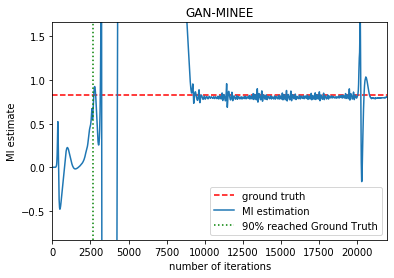

mi 0.8303656034108255


In [7]:
mi_ma_rate = 0.01
mi_array = np.array(mi_list)
for i in range(1,len(mi_array)):
    mi_list[i] = (1-mi_ma_rate) * mi_list[i-1] + mi_ma_rate * mi_list[i]
    
plt.axhline(mi,label='ground truth',linestyle='--',color='red')
plt.plot(mi_list, label='MI estimation')

for t in range(len(mi_array)):
    if (mi_list[t]>.9*mi):
        plt.axvline(t,label='90% reached Ground Truth',linestyle=':',color='green')
        break

plt.xlim((0,len(mi_array)))
plt.ylim((-mi,mi*2))
plt.title('GAN-MINEE')
plt.xlabel("number of iterations")
plt.ylabel("MI estimate")
plt.legend()

plt.show()
print('mi',mi)